In [4]:
import matplotlib.pyplot as plt
import numpy as np
from python_utils.electrostatic_maps_utils import read_map, circular_average, find_emap_profile
import os

In [5]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

In [6]:
pores = ["ahem", "mspa", "csgg", "wt", "k238a"]
# pores = ["ahem", "mspa", "k238a"]
colors = {"ahem": "#F75939", "mspa": "#F7B836", "k238a": "#309FF6", "wt": "#7F2DEB", "csgg": "#D4F733"}
labels = {"ahem": r"$\alpha$-haemolysin", "mspa": "MspA", "k238a": "Aerolysin K238A", "wt": "Aerolysin WT", "csgg": "CsgG"}
path = "/home/racoon/different_pores"
emap_paths = {pore: os.path.join(path, pore + "/electrostatic_map.dx") for pore in pores}
symmetry = {"ahem": 7, "mspa": 8, "k238a": 7, "wt": 7, "csgg": 9}

In [7]:
emaps = {pore: read_map(emap_paths[pore]) for pore in pores}
circ_av_emaps = {pore: circular_average(emaps[pore], symmetry[pore]) for pore in pores}

/home/racoon/different_pores/ahem/electrostatic_map.dx
(144, 144, 160)
Read density map. Size: (144, 144, 160)
/home/racoon/different_pores/mspa/electrostatic_map.dx
(128, 128, 144)
Read density map. Size: (128, 128, 144)
/home/racoon/different_pores/csgg/electrostatic_map.dx
(144, 144, 144)
Read density map. Size: (144, 144, 144)
/home/racoon/different_pores/wt/electrostatic_map.dx
(120, 120, 160)
Read density map. Size: (120, 120, 160)
/home/racoon/different_pores/k238a/electrostatic_map.dx
(120, 120, 160)
Read density map. Size: (120, 120, 160)


In [43]:

def find_center(emap):
    grid = np.meshgrid(range(emap.shape[0]), range(emap.shape[1]), indexing='ij')
    emap_sum = emap.sum(axis = 2)
    x_av = np.average(grid[0], weights=emap_sum)
    y_av = np.average(grid[1], weights=emap_sum)
    return x_av, y_av


def average_dens(array, r, x_av, y_av):
    z_step = 1
    X = np.arange(array.shape[0])
    Y = np.arange(array.shape[1])
    mask = ((X[np.newaxis,:] - x_av) ** 2 + (Y[:,np.newaxis] - y_av) ** 2 <= r ** 2)
    return np.sum(array[mask.T]) / (np.pi * r ** 2 * z_step)

def find_emap_profile(emap, pore, lim_diff=0.025):
    x_av, y_av = find_center(emap)
    r_all = []
    X = np.arange(emap.shape[0])
    Y = np.arange(emap.shape[1])
    i = 0
    lowlim = {"wt": 25, "k238a": 25}
    highlim = {"wt": 150, "k238a": 145}

    for array in np.rollaxis(emap, 2):
        r = 2
        dr = 1
        diff = 0
        if (pore in ["wt", "k238a"]) and (i < lowlim[pore] or i > highlim[pore]):
            r_all.append(emap.shape[0] / 2)
        else:
            while diff <= lim_diff and r < emap.shape[0] / 2:
                mask_ring = np.logical_and(((X[np.newaxis, :] - int(x_av)) ** 2 + (Y[:, np.newaxis] - int(y_av)) ** 2 <= (r + dr) ** 2),
                                        ((X[np.newaxis, :] - int(x_av)) ** 2 + (Y[:, np.newaxis] - int(y_av)) ** 2 >= r ** 2))
                mask_disk = ((X[np.newaxis, :] - x_av) ** 2 + (Y[:, np.newaxis] - y_av) ** 2 <= r ** 2)
                r += dr
                diff = np.average(array[mask_ring.T]) - np.average(array[mask_disk.T])
            r_all.append(r)
        i += 1

    emap_profile = [average_dens(array, r, x_av, y_av) for (array, r) in zip(np.rollaxis(emap, 2), r_all)]
    return x_av, y_av, r_all, emap_profile

In [44]:
x_av = {}
y_av = {}
r_all = {}
emap_profile = {}
lim_diff = {"ahem": 0.025, "mspa": 0.025, "k238a": 0.025, "wt": 0.025, "csgg": 0.025}
for pore in pores:
    print(pore)

    x_av[pore], y_av[pore], r_all[pore], emap_profile[pore] = find_emap_profile(circ_av_emaps[pore], pore, lim_diff=lim_diff[pore])

ahem
mspa
csgg
wt
k238a


In [45]:
gridmin = {"ahem": [0, 0, 0], "mspa": [-8, -7, -3], "k238a": [0, 0, 40], "wt": [-4, -4, 16], "csgg": [-71, -74, -47]}
gridmax = {"ahem": [149, 149, 149], "mspa": [134, 131, 143], "k238a": [117, 117, 190], "wt": [121, 119, 171], "csgg": [72, 71, 105]}
memb_com = {"ahem": [66, 66, 45], "mspa": [63, 60, 43], "k238a": [59, 57, 93], "wt": [59, 57, 75], "csgg": [1, -2, -4]}

# Very bad
tick_positions = {pore: [np.arange(circ_av_emaps[pore].shape[i]) for i in range(3)] for pore in pores}
tick_labels = {pore: [coord - (memb_com[pore][i] - gridmin[pore][i]) for i, coord in enumerate(tick_positions[pore])] for pore in pores}
tick_labels_x = {pore: tick_positions[pore][0] - int(x_av[pore]) for pore in pores}
tick_start = {"ahem": [11, 14, 5], "mspa": [3, 3, 6], "k238a": [19, 19, 13], "wt": [19, 19, 19], "csgg": [11, 19, 3]}
tick_pstart = {"ahem": [0, 14, 5], "mspa": [0, 3, 26], "k238a": [0, 19, 13], "wt": [0, 19, 12], "csgg": [0, 19, 9]}
membrane_thickness = 112 - 70

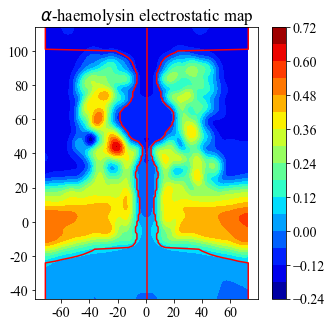

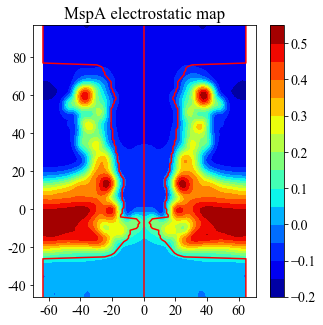

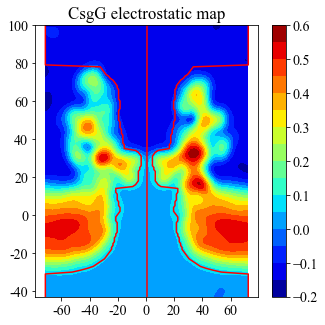

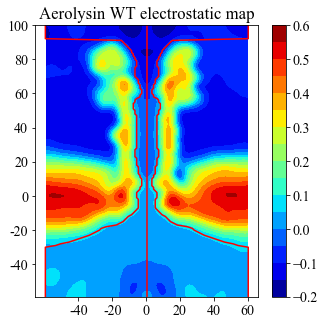

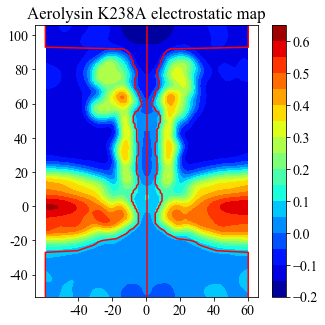

In [47]:
for pore in pores:
    plt.figure(figsize=(5, 5))
    Z = np.arange(circ_av_emaps[pore].shape[2])
    plt.contourf(np.rot90(circ_av_emaps[pore][:, int(y_av[pore]), :], k=3), cmap='jet', levels=15)
    plt.plot([y_av[pore]] * len(Z), Z, "r")
    plt.plot(y_av[pore] + r_all[pore], Z, "r")
    plt.plot(y_av[pore] - r_all[pore], Z, "r")
    plt.title(labels[pore] + " electrostatic map")
    plt.colorbar()
    plt.xticks(tick_positions[pore][0][tick_start[pore][0]::20], tick_labels_x[pore][tick_start[pore][0]::20])
    plt.yticks(tick_positions[pore][2][tick_start[pore][2]::20], tick_labels[pore][2][tick_start[pore][2]::20])
    plt.savefig("plots/" + pore + "emap_vertical.png")
    plt.savefig("plots/" + pore + "emap_vertical.svg")



    # plt.figure(figsize=(5, 5))
    # plt.contourf(circ_av_emaps[pore][:, :, 80], cmap='jet')
    # plt.title(labels[pore] + " electrostatic map")
    # plt.colorbar()   
    # plt.savefig("plots/" + pore + "emap_horizontal.png")
    # plt.savefig("plots/" + pore + "emap_horizontal.svg")

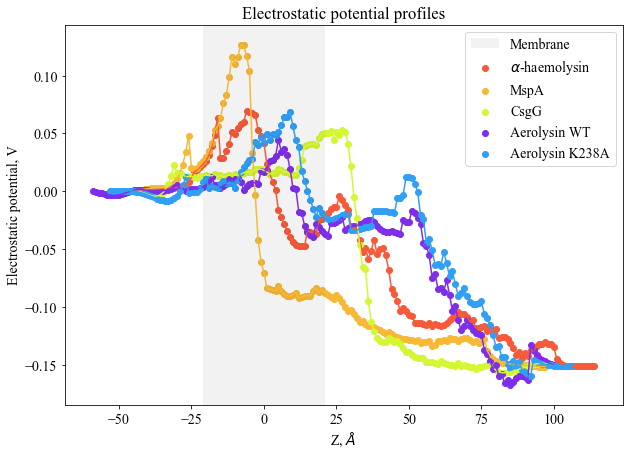

In [50]:
plt.figure(figsize=(10, 7))
plt.axvspan(0- membrane_thickness / 2, 0 + membrane_thickness / 2, 0, 1, alpha=0.05, label="Membrane", facecolor="black" )
for pore in pores:
    plt.title("Electrostatic potential profiles")
    plt.plot(tick_labels[pore][2], emap_profile[pore] - emap_profile[pore][0], c=colors[pore])
    plt.scatter(tick_labels[pore][2], emap_profile[pore] - emap_profile[pore][0], label=labels[pore], c=colors[pore])
    plt.xlabel(r"Z, $\AA$")
    plt.ylabel("Electrostatic potential, V")
    plt.legend()
    plt.savefig("plots/emap_profile.png")
    plt.savefig("plots/emap_profile.svg")